In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#用于运行的 epsilon 值列表。 在列表中保留 0 很重要，因为它表示原始测试集上的模型性能。 
#同样，从直觉上讲，我们期望ε越大，扰动越明显，但是从降低模型准确性的角度来看，攻击越有效。 
#由于此处的数据范围是，因此 epsilon 值不得超过 1。
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [3]:
#预训练 MNIST 模型
pretrained_model = "/home/msy/jupyterProjects/data/lenet_mnist_model.pth"
use_cuda=True

In [4]:
#要被攻击的MNIST模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/home/msy/jupyterProjects/data//MINIST', 
        train=False, 
        #download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),]
        )
    ),
    batch_size=1, shuffle=True
)

In [6]:
# 是否使用GPU
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Initialize the network
model=Net().to(device)

In [8]:
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [9]:
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
# FGSM attack code
'''
perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))
'''
#干净图像x, epsilon 是像素级扰动量(ϵ）,data_grad是输入图像的loss的梯度(∇xJ(θ,x,y))
def fgsm_attack(image, epsilon, data_grad):
    #collect the element-wise sign of the data gradient
    sign_data_grad=data_grad.sign()
    #create the preturbed image by adjusting each pixel of the input image
    pertured_image=image+epsilon*sign_data_grad
    #Adding clipping to maintian[0,1] range
    pertured_image=torch.clamp(pertured_image,0,1)
    #return the perturbed image
    return pertured_image

In [14]:
#对于测试集中的每个样本，该函数都会计算输入数据(data_grad）的损耗梯度，
#使用fgsm_attack(perturbed_data）创建一个扰动图像，然后检查受到扰动的例子是否有对抗性的
def test(model,device,test_loader,epsilon):
    #Accurary counter
    correct=0
    adv_examples= []
    
    #Loop over all examples in test set
    for data,target in test_loader:
        #Send the data and labels to the device
        data,target=data.to(device),target.to(device)
        
        #Set requires_grad attribute of tensor.Important for Attack
        data.requires_grad=True
        
        # Forward pass the data through the model
        output=model(data)
        init_pred = output.max(1,keepdim=True)[1]#get the index of the max log-probability
        
        #如果还没攻击就分错了，就跳过 
        if init_pred.item()!=target.item():
            continue
        
        # Calculate the loss
        loss=F.nll_loss(output,target)
        
        # Zero all existing gradients
        model.zero_grad()
        
        # Calculate gradients of model in backward pass
        loss.backward()
        
        #collect datagrad
        data_grad=data.grad.data
        
        #使用FGSM Attack，生成一张攻击图像
        perturbed_data=fgsm_attack(data,epsilon,data_grad)
        
        #用刚生成的攻击图像放进模型测一次
        output=model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


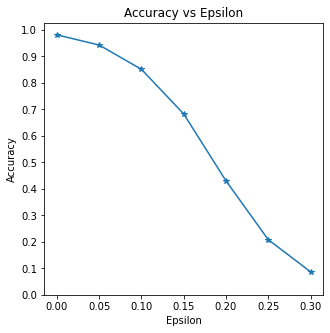

In [16]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

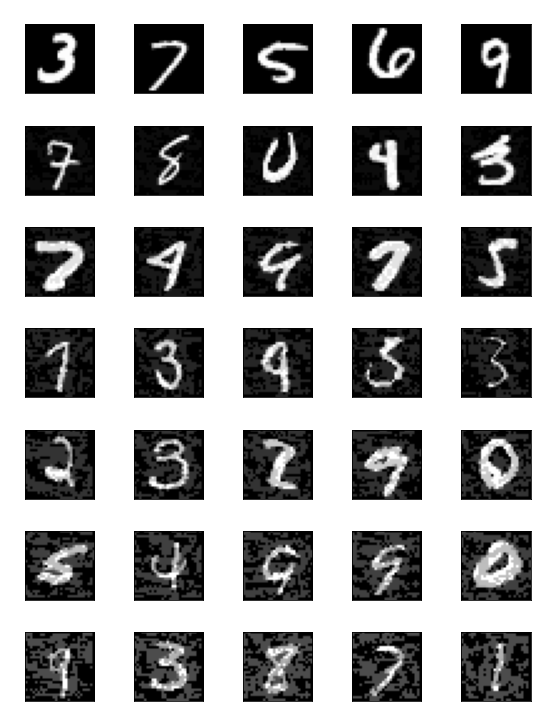

In [34]:
# 显示出每个epsilon的生成的扰动input
cnt = 0
font = {'family' : 'serif',  
        'color'  : 'white',  
        'weight' : 'normal',  
        'size'   : 14,  
        }  
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt+=1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([],[])
        plt.yticks([],[])
        plt
        if j==0:
            plt.ylabel("Eps:{}".format(epsilons[i]),fontdict=font)
        orig,adv,ex = examples[i][j]
        plt.title("{}->{}".format(orig,adv),color="white",size=15)
        plt.imshow(ex,cmap="gray")
plt.tight_layout()
plt.show()